In [2]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 96.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 86.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5),
                                     (0.5, 0.5, 0.5))
])


trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
import torch
import math

class VPSDE:
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T

    def beta(self, t):
        # t in [0,1], shape [B]
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def int_beta(self, t):
        # ∫0^t beta(s) ds for linear beta
        return self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * t**2

    def alpha(self, t):
        # alpha(t) = exp(-1/2 \int beta)
        return torch.exp(-0.5 * self.int_beta(t))

    def sigma(self, t):
        # sigma(t) = sqrt(1 - alpha(t)^2)
        a = self.alpha(t)
        return torch.sqrt(1.0 - a*a).clamp(min=1e-5)

    def diffusion(self, t):
        # g(t) = sqrt(beta(t))
        return torch.sqrt(self.beta(t)).clamp(min=1e-5)

    def drift(self, x, t):
        # f(x,t) = -1/2 beta(t) x
        b = self.beta(t).view(-1, 1, 1, 1)
        return -0.5 * b * x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeEmbedding(nn.Module):
    """
    Sinusoidal timestep embedding -> small MLP.
    Produces a vector of size time_dim.
    """
    def __init__(self, dim=128, hidden_mult=4):
        super().__init__()
        self.dim = dim
        hidden = dim * hidden_mult
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t: [B] (float)
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=t.device, dtype=t.dtype)
            * -(torch.log(torch.tensor(10000.0, device=t.device, dtype=t.dtype)) / half_dim)
        )
        args = t[:, None] * freqs[None, :]  # [B, half_dim]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # [B, dim]
        return self.mlp(emb)

class ResBlockFiLM(nn.Module):
    """
    ResBlock with FiLM conditioning from an embedding vector (time+label).
    Conditioning is applied as scale+shift after GroupNorm:
        h = GN(h) * (1 + scale) + shift
    """
    def __init__(self, in_ch, out_ch, emb_dim, groups=32, dropout=0.0):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch

        self.norm1 = nn.GroupNorm(groups, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, 2 * out_ch),
        )

        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x, emb):
        # x: [B,C,H,W], emb: [B, emb_dim]
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        h = self.norm2(h)
        scale_shift = self.emb_proj(emb)  # [B, 2*out_ch]
        scale, shift = torch.chunk(scale_shift, 2, dim=1)
        scale = scale[:, :, None, None]
        shift = shift[:, :, None, None]
        h = h * (1.0 + scale) + shift

        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        return h + self.skip(x)

class SelfAttention2d(nn.Module):
    def __init__(self, channels, num_heads=4, gn_groups=32):
        super().__init__()
        assert channels % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.scale = self.head_dim ** -0.5

        self.norm = nn.GroupNorm(gn_groups, channels)
        self.qkv = nn.Conv2d(channels, 3 * channels, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        # x: [B,C,H,W]
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)  # [B,3C,H,W]
        q, k, v = qkv.chunk(3, dim=1)

        # flatten spatial
        N = H * W
        q = q.view(B, self.num_heads, self.head_dim, N).permute(0, 1, 3, 2)  # [B,h,N,d]
        k = k.view(B, self.num_heads, self.head_dim, N)                      # [B,h,d,N]
        v = v.view(B, self.num_heads, self.head_dim, N).permute(0, 1, 3, 2)  # [B,h,N,d]

        attn = (q @ k) * self.scale  # [B,h,N,N]
        attn = attn.softmax(dim=-1)

        out = attn @ v  # [B,h,N,d]
        out = out.permute(0, 1, 3, 2).contiguous().view(B, C, H, W)
        out = self.proj(out)
        return x + out

class UNetCIFAR3Level_Attn_CFG(nn.Module):
    """
    ε-prediction U-Net with attention at 32x32, 16x16, 8x8 and 4x4,
    plus classifier-free guidance conditioning.
    """
    def __init__(
        self,
        time_dim=128,
        base_channels=128,
        img_channels=3,
        num_classes=10,
        attn_heads=4,
        dropout=0.0,
        gn_groups=32,
    ):
        super().__init__()
        self.time_dim = time_dim
        self.num_classes = num_classes
        self.null_label = num_classes

        self.time_mlp = TimeEmbedding(dim=time_dim)
        self.label_emb = nn.Embedding(num_classes + 1, time_dim)

        C = base_channels
        emb_dim = time_dim

        # Stem
        self.in_conv = nn.Conv2d(img_channels, C, 3, padding=1)

        # Encoder
        self.down1 = ResBlockFiLM(C, C, emb_dim, groups=gn_groups, dropout=dropout)
        self.attn32 = SelfAttention2d(C, num_heads=attn_heads, gn_groups=gn_groups)
        self.pool1 = nn.MaxPool2d(2)  

        self.down2 = ResBlockFiLM(C, 2 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.attn16 = SelfAttention2d(2 * C, num_heads=attn_heads, gn_groups=gn_groups)
        self.pool2 = nn.MaxPool2d(2)  

        self.down3 = ResBlockFiLM(2 * C, 4 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.attn8 = SelfAttention2d(4 * C, num_heads=attn_heads, gn_groups=gn_groups)
        self.pool3 = nn.MaxPool2d(2) 

        self.bottleneck = ResBlockFiLM(4 * C, 8 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.attn4 = SelfAttention2d(8 * C, num_heads=attn_heads, gn_groups=gn_groups)

        # Decoder
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(8 * C, 4 * C, 3, padding=1),
        )
        self.dec3 = ResBlockFiLM(8 * C, 4 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.dec3_attn = SelfAttention2d(4 * C, num_heads=attn_heads, gn_groups=gn_groups)

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(4 * C, 2 * C, 3, padding=1),
        )
        self.dec2 = ResBlockFiLM(4 * C, 2 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.dec2_attn16 = SelfAttention2d(2 * C, num_heads=attn_heads, gn_groups=gn_groups)

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(2 * C, C, 3, padding=1),
        )
        self.dec1 = ResBlockFiLM(2 * C, C, emb_dim, groups=gn_groups, dropout=dropout)
        self.dec1_attn32 = SelfAttention2d(C, num_heads=attn_heads, gn_groups=gn_groups)

        self.out_norm = nn.GroupNorm(gn_groups, C)
        self.out_conv = nn.Conv2d(C, img_channels, 3, padding=1)

    def forward(self, x, t, y=None):
        B = x.shape[0]

        temb = self.time_mlp(t)

        if y is None:
            y = torch.full((B,), self.null_label, device=x.device, dtype=torch.long)
        yemb = self.label_emb(y)

        emb = temb + yemb

        # Stem
        h0 = self.in_conv(x)

        # Encoder
        d1 = self.down1(h0, emb)   
        d1 = self.attn32(d1)
        p1 = self.pool1(d1)        

        d2 = self.down2(p1, emb)
        d2 = self.attn16(d2)
        p2 = self.pool2(d2)        

        d3 = self.down3(p2, emb)
        d3 = self.attn8(d3)
        p3 = self.pool3(d3)        

        # Bottleneck
        b = self.bottleneck(p3, emb)
        b = self.attn4(b)

        # Decoder
        u3 = self.up3(b)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.dec3(u3, emb)
        u3 = self.dec3_attn(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.dec2(u2, emb)
        u2 = self.dec2_attn16(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.dec1(u1, emb)
        u1 = self.dec1_attn32(u1)

        out = self.out_norm(u1)
        out = F.silu(out)
        out = self.out_conv(out)
        return out


In [7]:
@torch.no_grad()
def vp_sample_xt(x0, t, sde):
    """
    x0: [B,3,32,32], t: [B]
    returns xt, eps where xt = alpha x0 + sigma eps
    """
    a = sde.alpha(t).view(-1, 1, 1, 1)
    s = sde.sigma(t).view(-1, 1, 1, 1)
    eps = torch.randn_like(x0)
    xt = a * x0 + s * eps
    return xt, eps


In [ ]:
import os
import torch
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# config
ckpt_path = "vp_cfg_ckpt3.pth"

num_classes = 10
p_uncond = 0.1          # probability of dropping label (uncond branch)
ema_decay = 0.999
t_min = 1e-4

beta_min = 0.1
beta_max = 20.0
T = 1.0

time_dim = 32
base_channels = 128
img_channels = 3
attn_heads = 4

lr = 3e-5
weight_decay = 1e-4

num_epochs_total = 150   # total epochs you want to reach
save_every = 10


@torch.no_grad()
def update_ema(ema_model, model, decay):
    for p_ema, p in zip(ema_model.parameters(), model.parameters()):
        p_ema.data.mul_(decay).add_(p.data, alpha=1 - decay)


# build SDE
sde = VPSDE(beta_min=beta_min, beta_max=beta_max, T=T)

# build models 
model = UNetCIFAR3Level_Attn_CFG(
    time_dim=time_dim,
    base_channels=base_channels,
    img_channels=img_channels,
    num_classes=num_classes,
    attn_heads=attn_heads,
).to(device)

ema_model = UNetCIFAR3Level_Attn_CFG(
    time_dim=time_dim,
    base_channels=base_channels,
    img_channels=img_channels,
    num_classes=num_classes,
    attn_heads=attn_heads,
).to(device)

# optimizer 
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# resume-or-start 
start_epoch = 0
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    ema_model.load_state_dict(ckpt["ema_state"])
    if "optimizer_state" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state"])

    # restore lr (optimizer state restores old lr)
    for g in optimizer.param_groups:
        g["lr"] = lr
        g["weight_decay"] = weight_decay

    start_epoch = int(ckpt.get("epoch", -1)) + 1
    print(f"Resuming from {ckpt_path} at epoch {start_epoch} (lr={optimizer.param_groups[0]['lr']})")

else:
    ema_model.load_state_dict(model.state_dict())
    print(f"No checkpoint found at {ckpt_path}. Starting fresh.")


# training 
end_epoch = num_epochs_total

for epoch in range(start_epoch, end_epoch):
    model.train()
    epoch_loss = 0.0
    n_batches = 0

    for x0, y in loader:
        x0 = x0.to(device)
        y = y.to(device)

        # classifier-free guidance label dropout
        # replace some labels with null label (= num_classes)
        drop = (torch.rand(y.size(0), device=device) < p_uncond)
        y_drop = y.clone()
        y_drop[drop] = num_classes  # null label index

        t = t_min + (1.0 - t_min) * torch.rand(x0.size(0), device=device)
        xt, eps = vp_sample_xt(x0, t, sde)

        eps_pred = model(xt, t, y_drop)

        loss = F.mse_loss(eps_pred, eps)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        update_ema(ema_model, model, ema_decay)

        epoch_loss += loss.item()
        n_batches += 1

    mean_loss = epoch_loss / max(n_batches, 1)
    print(f"Epoch {epoch+1}/{end_epoch}: mean loss = {mean_loss:.4f}")

    # checkpoint
    if (epoch + 1) % save_every == 0 or (epoch + 1) == end_epoch:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "ema_state": ema_model.state_dict(),
                "optimizer_state": optimizer.state_dict(),

                "beta_min": beta_min,
                "beta_max": beta_max,
                "T": T,
                "time_dim": time_dim,
                "base_channels": base_channels,
                "img_channels": img_channels,
                "attn_heads": attn_heads,
                "num_classes": num_classes,
                "p_uncond": p_uncond,
                "t_min": t_min,
                "lr": lr,
                "weight_decay": weight_decay,
            },
            ckpt_path,
        )
        print(f"Checkpoint saved at epoch {epoch+1} → {ckpt_path}")


Resuming from vp_cfg_ckpt3.pth at epoch 150 (lr=3e-05)


In [ ]:
def cfg_rescale_eps(eps_guided, eps_cond, rescale=0.5, eps=1e-8):
    """
    Match per-sample std of guided eps to conditional eps (then blend).
    rescale=0.0 -> no change (standard CFG)
    Typical: 0.3–0.8
    """
    if rescale <= 0:
        return eps_guided

    std_g = eps_guided.flatten(1).std(dim=1, keepdim=True).clamp_min(eps).view(-1, 1, 1, 1)
    std_c = eps_cond.flatten(1).std(dim=1, keepdim=True).clamp_min(eps).view(-1, 1, 1, 1)

    eps_rs = eps_guided * (std_c / std_g)
    return eps_guided * (1.0 - rescale) + eps_rs * rescale


In [ ]:
import torch

@torch.no_grad()
def sample_prob_flow_heun_eps_cfg_stable(
    model,
    sde,
    y,                       # [B] labels in {0..num_classes-1}
    w=2.0,                   # base guidance scale
    num_steps=500,           
    device="cuda",
    t_min=1e-2,              # IMPORTANT: stop earlier to avoid sigma -> 0 stiffness
    img_size=32,
    img_channels=3,
    null_label=10,
    clamp_x=True,
    clamp_val=2.0,
    time_power=2.0,          
    guidance_taper="sigma",  
    cfg_rescale=0.5,   
):
    """
    Heun (RK2) solver for VP probability-flow ODE using epsilon-prediction + CFG,
    with stability improvements:
      - non-uniform t grid (bias toward small t)
      - CFG tapering near t_min
      - optional clamping of x
      - avoid integrating to extremely small t_min
    """

    model.eval()
    B = y.shape[0]
    y = y.to(device).long()
    y_null = torch.full((B,), null_label, device=device, dtype=torch.long)

    # ---- non-uniform time grid: more points near small t ----
    # Build u in [0,1], then map to t in [t_min, 1], then reverse (1 -> t_min)
    u = torch.linspace(0.0, 1.0, num_steps, device=device)
    t_grid = t_min + (1.0 - t_min) * (u ** time_power)
    t_grid = torch.flip(t_grid, dims=[0])  # 1 -> t_min

    x = torch.randn(B, img_channels, img_size, img_size, device=device)

    sigma_max = sde.sigma(torch.ones(1, device=device)).item()

    def ode_drift(x, t_scalar):
        t = torch.full((B,), t_scalar, device=device)

        beta  = sde.beta(t).view(B, 1, 1, 1)
        sigma = sde.sigma(t).view(B, 1, 1, 1)

        eps_u = model(x, t, y_null)
        eps_c = model(x, t, y)
        delta = eps_c - eps_u

        # guidance taper to avoid blow-up as sigma -> 0 
        if guidance_taper == "sigma":
            w_t = w * (sigma / sigma_max)
        elif guidance_taper == "linear_t":
            w_t = w * t.view(B, 1, 1, 1)
        else:
            w_t = w

        # CFG + rescale 
        eps_guided = eps_u + w_t * delta
        eps = cfg_rescale_eps(eps_guided, eps_c, rescale=cfg_rescale)


        # VP probability-flow ODE drift for eps-pred:
        # score = -eps/sigma
        # dx/dt = f - 0.5 g^2 score = -0.5 beta x + 0.5 beta eps / sigma
        drift = (-0.5 * beta * x) + (0.5 * beta * eps / sigma)

        return drift

    for i in range(num_steps - 1):
        t0 = t_grid[i].item()
        t1 = t_grid[i + 1].item()
        dt = t1 - t0  

        k1 = ode_drift(x, t0)
        x_pred = x + dt * k1
        k2 = ode_drift(x_pred, t1)

        x = x + 0.5 * dt * (k1 + k2)

        if clamp_x:
            x = x.clamp(-clamp_val, clamp_val)

    return x


In [9]:
@torch.no_grad()
def sample_one_per_class(model, sde, w=2.0, num_steps=200, device="cuda", t_min=1e-2):
    labels = torch.arange(10, device=device)  # [0..9]
    samples = sample_prob_flow_heun_eps_cfg_stable(
        model=model,
        sde=sde,
        y=labels,
        w=w,
        num_steps=num_steps,
        device=device,
        t_min=t_min,
        img_size=32,
        img_channels=3,
        null_label=10,
    )
    return samples, labels


In [10]:
CIFAR10_NAMES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def to_01(x):
    # model outputs in [-1,1] domain (because training images are normalized)
    return (x.clamp(-1, 1) + 1) / 2.0

def show_class_row(samples, labels=None, title="One sample per class"):
    """
    samples: [B,3,32,32] in [-1,1]
    labels:  [B] optional
    """
    x = to_01(samples.detach().cpu())
    B = x.size(0)

    plt.figure(figsize=(2*B, 2.5))
    for i in range(B):
        plt.subplot(1, B, i+1)
        img = x[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis("off")
        if labels is not None:
            lbl = int(labels[i])
            plt.title(CIFAR10_NAMES[lbl], fontsize=9)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [11]:
def show_grid(samples, nrow=4, title="Samples"):
    x = to_01(samples.detach().cpu())
    B = x.size(0)
    ncol = math.ceil(B / nrow)
    plt.figure(figsize=(2*ncol, 2*nrow))
    for i in range(B):
        plt.subplot(nrow, ncol, i+1)
        img = x[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import torch
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# config 
ckpt_path = "vp_cfg_ckpt3.pth"

num_classes = 10
p_uncond = 0.1          # probability of dropping label (uncond branch)
ema_decay = 0.999
t_min = 1e-4

beta_min = 0.1
beta_max = 20.0
T = 1.0

time_dim = 32
base_channels = 128
img_channels = 3
attn_heads = 4

lr = 3e-5
weight_decay = 1e-4

num_epochs_total = 200   # total epochs you want to reach
save_every = 10


@torch.no_grad()
def update_ema(ema_model, model, decay):
    for p_ema, p in zip(ema_model.parameters(), model.parameters()):
        p_ema.data.mul_(decay).add_(p.data, alpha=1 - decay)


# build SDE
sde = VPSDE(beta_min=beta_min, beta_max=beta_max, T=T)

# build models
model = UNetCIFAR3Level_Attn_CFG(
    time_dim=time_dim,
    base_channels=base_channels,
    img_channels=img_channels,
    num_classes=num_classes,
    attn_heads=attn_heads,
).to(device)

ema_model = UNetCIFAR3Level_Attn_CFG(
    time_dim=time_dim,
    base_channels=base_channels,
    img_channels=img_channels,
    num_classes=num_classes,
    attn_heads=attn_heads,
).to(device)

In [19]:
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
ema_model.load_state_dict(ckpt["ema_state"])

<All keys matched successfully>

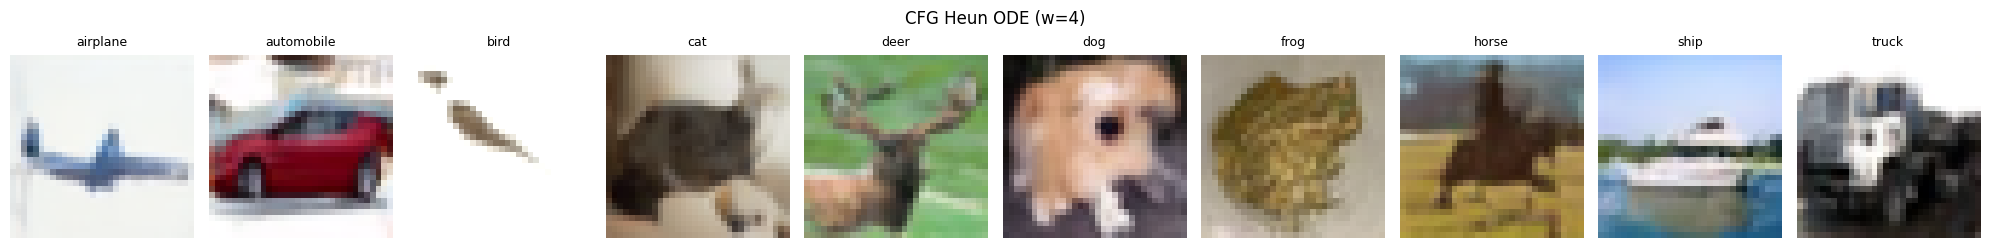

In [21]:
samples, labels = sample_one_per_class(ema_model, sde, w=4, num_steps=500, device=device, t_min=1e-4)
show_class_row(samples, labels, title="CFG Heun ODE (w=4)")